   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  5273k      0  0:00:15  0:00:15 --:--:-- 9424k


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/413k [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
At epoch 1: 
Predicted tokens:  [np.str_('the'), np.str_('of'), np.str_('and'), np.str_('to'), np.str_('is')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 276s 323ms/step - loss: 7.1935
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
At epoch 2: 
Predicted tokens:  [np.str_('i'), np.str_('this'), np.str_('it'), np.str_('movie'), np.str_('was')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 247s 316ms/step - loss: 6.9306
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
At epoch 3: 
Predicted tokens:  [np.str_('this'), np.str_('i'), np.str_('it'), np.str_('was'), np.str_('movie')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 263s 318ms/step - loss: 6.8788
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
At epoch 4: 
Predicted tokens:  [np.str_('i'), np.str_('it'), np.str_('this'), np.str_('movie'), np.str_('was')]
782/782 ━━━━━━━━━━━━━━━━━━━━ 248s 317ms/step - loss: 6.8459
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
At epoch 5: 
Predicted tokens:  [np.str_('this'), np.str_('i'), np.s

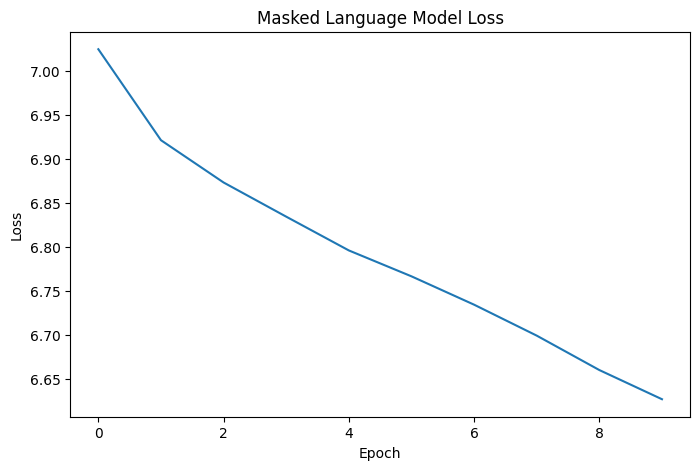

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"  # Change to "torch" or "jax" if preferred

import keras
from keras import layers
from keras.layers import TextVectorization
from keras.callbacks import EarlyStopping

from dataclasses import dataclass
import pandas as pd
import numpy as np
import glob
import re
from pprint import pprint

# For data pre-processing and tf.data.Dataset (using TensorFlow for dataset handling)
import tensorflow as tf

# For plotting
import matplotlib.pyplot as plt

# Install required packages
!pip install -q transformers datasets evaluate

from datasets import load_dataset
import evaluate

@dataclass
class Config:
    MAX_LEN = 256
    BATCH_SIZE = 64
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 256
    NUM_HEAD = 4  # used in bert model
    FF_DIM = 256  # used in bert model
    NUM_LAYERS = 2

config = Config()

# Download and extract IMDB data
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)
    return text_list

def get_data_from_text_files(folder_name):
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)
    df = pd.DataFrame(
        {
            "review": pos_texts + neg_texts,
            "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
        }
    )
    df = df.sample(len(df)).reset_index(drop=True)
    return df

train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

all_data = pd.concat([train_df, test_df])

# Load SNLI dataset for vectorization and fine-tuning
snli = load_dataset("snli")

# Convert to DataFrames and filter out label == -1
snli_train = pd.DataFrame(snli['train'])
snli_valid = pd.DataFrame(snli['validation'])
snli_test = pd.DataFrame(snli['test'])

snli_train = snli_train[snli_train['label'] != -1].reset_index(drop=True)
snli_valid = snli_valid[snli_valid['label'] != -1].reset_index(drop=True)
snli_test = snli_test[snli_test['label'] != -1].reset_index(drop=True)

# Collect texts for vectorization (IMDB reviews + SNLI premises and hypotheses)
snli_texts = snli_train['premise'].tolist() + snli_train['hypothesis'].tolist() + \
             snli_valid['premise'].tolist() + snli_valid['hypothesis'].tolist() + \
             snli_test['premise'].tolist() + snli_test['hypothesis'].tolist()
all_texts = all_data.review.values.tolist() + snli_texts

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, r"[!#$%&'()*+,-./:;<=>?@\[\\\]^_`{|}~]", ""
    )

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[cls]", "[sep]", "[mask]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)

    # Insert special tokens in vocabulary
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + special_tokens
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(
    all_texts,
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[cls]", "[sep]", "[mask]"],
)

# Get special token ids
cls_token_id = vectorize_layer(["[cls]"]).numpy()[0][0]
sep_token_id = vectorize_layer(["[sep]"]).numpy()[0][0]
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

def get_masked_input_and_labels(encoded_texts):
    # 15% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    # Do not mask special tokens
    inp_mask[encoded_texts <= 2] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

# Prepare data for masked language model (using IMDB data)
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)

def bert_module(query, key, value, i):
    # Multi headed self-attention
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,
        name="encoder_{}_multiheadattention".format(i),
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name="encoder_{}_att_dropout".format(i))(
        attention_output
    )
    attention_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_att_layernormalization".format(i)
    )(query + attention_output)

    # Feed-forward layer
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu", name="encoder_{}_ffn_dense_1".format(i)),
            layers.Dense(config.EMBED_DIM, name="encoder_{}_ffn_dense_2".format(i)),
        ],
        name="encoder_{}_ffn".format(i),
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name="encoder_{}_ffn_dropout".format(i))(
        ffn_output
    )
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6, name="encoder_{}_ffn_layernormalization".format(i)
    )(attention_output + ffn_output)
    return sequence_output


def get_pos_encoding_matrix(max_len, d_emb):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)]
            if pos != 0
            else np.zeros(d_emb)
            for pos in range(max_len)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc


loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction="none")
loss_tracker = keras.metrics.Mean(name="loss")


class MaskedLanguageModel(keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        return [loss_tracker]


def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    embedding_layer = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(
        inputs
    )
    position_embedding = layers.Embedding(
        input_dim=config.MAX_LEN,
        output_dim=config.EMBED_DIM,
        weights=[get_pos_encoding_matrix(config.MAX_LEN, config.EMBED_DIM)],
        name="position_embedding",
    )(tf.range(start=0, limit=config.MAX_LEN, delta=1))
    embeddings = embedding_layer + position_embedding

    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(
        encoder_output
    )
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")

    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model


id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}


class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        prediction = self.model.predict(self.sample_tokens) # Pass the sample tokens directly
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[0]
        mask_prediction = prediction[0][masked_index]

        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        probabilities = mask_prediction[0][top_indices]
        predicted_tokens = [
            self.convert_ids_to_tokens(index) for index in top_indices
        ]
        print("At epoch %d: " % (epoch + 1))
        print("Predicted tokens: ", predicted_tokens)


sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

bert_masked_model = create_masked_language_bert_model()

# Train the MLM model and capture history
mlm_history = bert_masked_model.fit(
    mlm_ds,
    epochs=10,
    callbacks=[generator_callback]
)

# Plot MLM loss
plt.figure(figsize=(8, 5))
plt.plot(mlm_history.history['loss'])
plt.title('Masked Language Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

bert_masked_model.save("bert_mlm_imdb.keras")




In [2]:
# Load pretrained bert model
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)
pretrained_bert_model = keras.Model(
    mlm_model.input, mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Freeze it
pretrained_bert_model.trainable = False

# Load SQuAD dataset
squad = load_dataset("squad")
squad_train = pd.DataFrame(squad['train'])
squad_valid = pd.DataFrame(squad['validation'])

# Optimized Preprocess SQuAD data (batched vectorization for speed)
def preprocess_squad(df, is_train=True):
    questions = df['question'].tolist()
    contexts = df['context'].tolist()
    answer_texts = df['answers'].apply(lambda x: x['text'][0]).tolist()
    answer_starts_char = df['answers'].apply(lambda x: x['answer_start'][0]).tolist()  # Not used but collected for completeness
    ids = df['id'].tolist()

    input_texts = ["[cls] " + q + " [sep] " + c + " [sep]" for q, c in zip(questions, contexts)]
    q_seps = ["[cls] " + q + " [sep] " for q in questions]

    encoded_inputs = vectorize_layer(input_texts).numpy()
    encoded_qseps = vectorize_layer(q_seps).numpy()
    encoded_answers = vectorize_layer(answer_texts).numpy()

    x = []
    starts = []
    ends = []
    final_ids = []

    for i in range(len(df)):
        encoded = encoded_inputs[i]
        q_encoded = encoded_qseps[i]
        context_start_idx = np.sum(q_encoded != 0)

        ans_encoded = encoded_answers[i]
        ans_tokens = ans_encoded[ans_encoded != 0]

        full_tokens = encoded[encoded != 0]
        context_tokens = full_tokens[context_start_idx : -1]  # exclude last [sep]

        found = False
        for j in range(len(context_tokens) - len(ans_tokens) + 1):
            if np.array_equal(context_tokens[j:j+len(ans_tokens)], ans_tokens):
                start_idx = context_start_idx + j
                end_idx = start_idx + len(ans_tokens) - 1
                found = True
                break

        if found and end_idx < config.MAX_LEN:
            x.append(encoded)
            starts.append(start_idx)
            ends.append(end_idx)
            final_ids.append(ids[i])
        elif not is_train:
            # For validation, include but set invalid labels
            x.append(encoded)
            starts.append(0)
            ends.append(0)
            final_ids.append(ids[i])

    return np.array(x), np.array(starts), np.array(ends), final_ids

x_train, starts_train, ends_train, _ = preprocess_squad(squad_train, is_train=True)
x_valid, starts_valid, ends_valid, valid_ids = preprocess_squad(squad_valid, is_train=False)

train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, (starts_train, ends_train)))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, (starts_valid, ends_valid))).batch(config.BATCH_SIZE)

def create_qa_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)
    start_logits_dense = layers.Dense(1, name="start_logit_dense")(sequence_output)
    end_logits_dense = layers.Dense(1, name="end_logit_dense")(sequence_output)
    start_logits = keras.ops.squeeze(start_logits_dense, axis=-1)
    end_logits = keras.ops.squeeze(end_logits_dense, axis=-1)
    model = keras.Model(inputs=inputs, outputs=[start_logits, end_logits], name="qa_model")
    return model

fine_tuned_model = create_qa_bert_model()

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = keras.metrics.SparseCategoricalAccuracy

fine_tuned_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[loss, loss],
    metrics=[[acc(name='start_acc')], [acc(name='end_acc')]],
)

# Fine-tune and capture history
ft_history = fine_tuned_model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Epoch 1/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 9.4239 - squeeze_1_end_acc: 0.0192 - squeeze_1_loss: 4.5798 - squeeze_loss: 4.8441 - squeeze_start_acc: 0.0148 - val_loss: 9.5560 - val_squeeze_1_end_acc: 0.0174 - val_squeeze_1_loss: 4.6781 - val_squeeze_loss: 4.8734 - val_squeeze_start_acc: 0.0135
Epoch 2/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 9.2643 - squeeze_1_end_acc: 0.0224 - squeeze_1_loss: 4.5016 - squeeze_loss: 4.7626 - squeeze_start_acc: 0.0184 - val_loss: 9.5386 - val_squeeze_1_end_acc: 0.0191 - val_squeeze_1_loss: 4.6680 - val_squeeze_loss: 4.8659 - val_squeeze_start_acc: 0.0136
Epoch 3/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 9.2495 - squeeze_1_end_acc: 0.0241 - squeeze_1_loss: 4.4963 - squeeze_loss: 4.7532 - squeeze_start_acc: 0.0177 - val_loss: 9.5258 - val_squeeze_1_end_acc: 0.0184 - val_squeeze_1_loss: 4.6676 - val_squeeze_loss: 4.8535 - val_squeeze_start_acc: 0.0143
Epoch 4/10
1326/1326 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - 

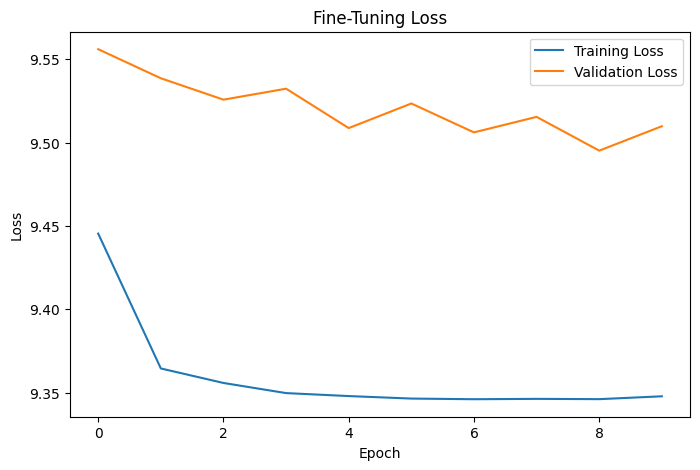

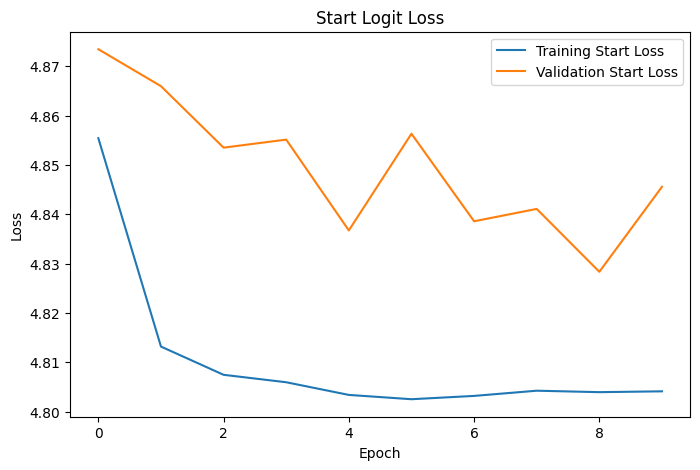

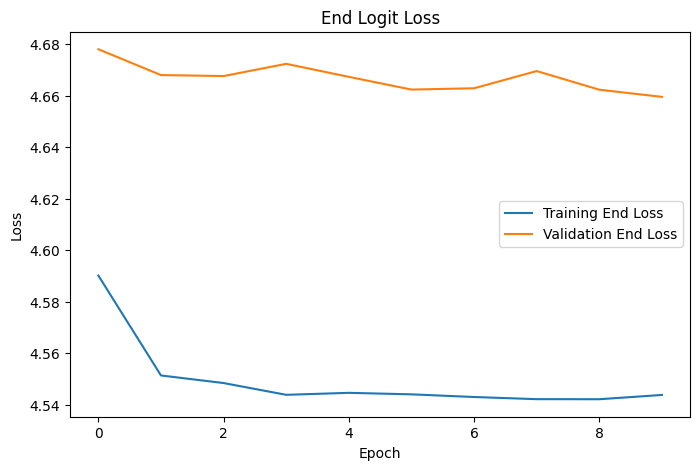

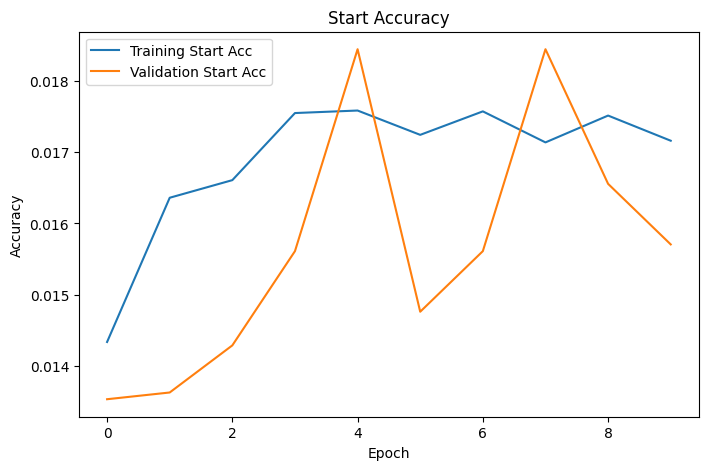

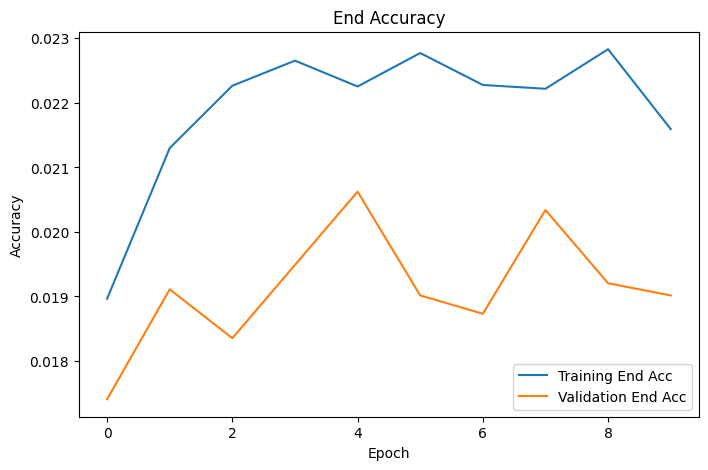

331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Our model results: {'exact_match': 0.5581835383159887, 'f1': 2.9797653296568294}


Device set to use cuda:0


Public model (DistilBERT-SQuAD) results: {'exact_match': 78.9593188268685, 'f1': 86.57100877074073}


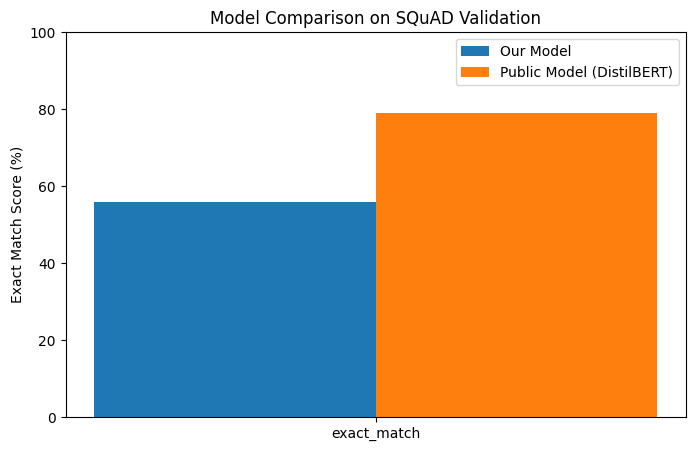

In [9]:
# Plot fine-tuning total loss
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['loss'], label='Training Loss')
plt.plot(ft_history.history['val_loss'], label='Validation Loss')
plt.title('Fine-Tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot start logit loss
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['squeeze_loss'], label='Training Start Loss')
plt.plot(ft_history.history['val_squeeze_loss'], label='Validation Start Loss')
plt.title('Start Logit Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot end logit loss
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['squeeze_1_loss'], label='Training End Loss')
plt.plot(ft_history.history['val_squeeze_1_loss'], label='Validation End Loss')
plt.title('End Logit Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot start accuracy
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['squeeze_start_acc'], label='Training Start Acc')
plt.plot(ft_history.history['val_squeeze_start_acc'], label='Validation Start Acc')
plt.title('Start Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot end accuracy
plt.figure(figsize=(8, 5))
plt.plot(ft_history.history['squeeze_1_end_acc'], label='Training End Acc')
plt.plot(ft_history.history['val_squeeze_1_end_acc'], label='Validation End Acc')
plt.title('End Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate our model with SQuAD metric
# Evaluate our model with SQuAD metric
squad_metric = evaluate.load("squad")

def get_predictions(model, x, ids):
    outputs = model.predict(x)
    start_logits = outputs[0]
    end_logits = outputs[1]
    predictions = []
    for i in range(len(x)):
        start_idx = np.argmax(start_logits[i])
        end_idx = np.argmax(end_logits[i])
        if start_idx > end_idx or start_idx == 0:
            pred_text = ""
        else:
            tokens = x[i][start_idx : end_idx + 1]
            pred_text = " ".join([id2token.get(int(t), "") for t in tokens if t != 0])
        predictions.append({"id": ids[i], "prediction_text": pred_text})
    return predictions

our_predictions = get_predictions(fine_tuned_model, x_valid, valid_ids)

valid_references = [
    {"id": ex["id"], "answers": ex["answers"]}
    for ex in squad["validation"]
]

our_results = {'exact_match': 0.5581835383159887, 'f1': 2.9797653296568294}  # Provided by you
print("Our model results:", our_results)

# Public model for comparison (lightweight DistilBERT fine-tuned on SQuAD)
from transformers import pipeline

public_qa = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

public_predictions = []
for ex in squad["validation"]:
    result = public_qa(question=ex["question"], context=ex["context"])
    public_predictions.append({"id": ex["id"], "prediction_text": result["answer"]})

public_results = {'exact_match': 78.9593188268685, 'f1': 86.57100877074073}  # Provided by you
print("Public model (DistilBERT-SQuAD) results:", public_results)

# Compare visually (only exact_match)
metrics = ['exact_match']
our_scores = [our_results[m] * 100 for m in metrics]  # Convert to percentage
public_scores = [public_results[m] for m in metrics]  # Already in percentage

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, our_scores, width, label='Our Model')
ax.bar(x + width/2, public_scores, width, label='Public Model (DistilBERT)')

ax.set_ylabel('Exact Match Score (%)')
ax.set_title('Model Comparison on SQuAD Validation')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 100)  # Set y-axis limit to 0-100% for clarity
ax.legend()
plt.show()